In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import glob

from datasets import *

pd.set_option("display.max_columns", 150)

In [3]:
# Load the data

main_page_df = enter.main_page()
# signup_df = enter.signup_page()
# fin_signup_df = complete.signup()
# content_page_df = enter.content_page()
# start_content_btn_df = click.content_page_start_content_button()
# more_review_btn_df = click.content_page_more_review_button()
payment_page_df = enter.payment_page()
subscription_df = complete.subscription()
renew_subs_df = renew.subscription()
resubscribe_df = resubscribe.subscription()
# free_trial_df = start.free_trial()
# start_content_df = start.content()
# episode_page_df = enter.lesson_page()
# comp_lesson_df = complete.lesson()
# lesson_reply_df = click.lesson_page_related_comment_box()
# end_content_df = end.content()
cancel_plan_df = click.cancel_plan_button()

## Dataset

### min_page_df

**enter.main_page.csv**<br/>
서비스 메인페이지 진입

In [3]:
main_page_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seongnam-si,2023-04-05 21:55:06.140000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21 5G,enter.main_page,Korean,Whale,1.0.0.0,Web,NaN
1,Dongdaemun-gu,2023-04-05 21:04:28.967000,South Korea,NaN,Mac,Mac,enter.main_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4
2,Hwaseong-si,2023-04-05 21:01:31.258000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
3,Hwaseong-si,2023-04-05 21:02:50.374000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
4,Seoul,2023-04-05 21:30:33.727000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.main_page,Korean,Chrome,112.0.0.0,Web,NaN
5,Sejong,2023-04-05 21:36:02.749000,South Korea,NaN,Apple iPhone,Apple iPhone 12 Mini,enter.main_page,Korean,Instagram,276.1.0.14.103,Web,NaN
6,Seoul,2023-04-05 21:37:37.469000,South Korea,NaN,Samsung SM-S916N,NaN,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
7,Seoul,2023-04-05 21:37:42.563000,South Korea,NaN,Samsung SM-S916N,NaN,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
8,Jung-gu,2023-04-05 21:55:29.031000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
9,Seoul,2023-04-05 21:05:40.020000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,16.4,Web,NaN


In [4]:
main_page_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133548 entries, 0 to 2133547
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   city               object 
 1   client_event_time  object 
 2   country            object 
 3   device_carrier     float64
 4   device_family      object 
 5   device_type        object 
 6   event_type         object 
 7   language           object 
 8   os_name            object 
 9   os_version         object 
 10  platform           object 
 11  user_id            object 
dtypes: float64(1), object(11)
memory usage: 195.3+ MB


In [5]:
# datetime 타입의 형식으로 모두 통일을 해주어야할 필요가 있음
main_page_df.client_event_time

0          2023-04-05 21:55:06.140000
1          2023-04-05 21:04:28.967000
2          2023-04-05 21:01:31.258000
3          2023-04-05 21:02:50.374000
4          2023-04-05 21:30:33.727000
                      ...            
2133543    2023-10-10 05:53:29.283000
2133544    2023-10-10 05:54:17.572000
2133545    2023-10-10 05:54:33.164000
2133546    2023-10-10 05:58:15.175000
2133547    2023-10-10 05:58:45.857000
Name: client_event_time, Length: 2133548, dtype: object

In [6]:
# 값 전체가 NaN임
main_page_df.device_carrier.value_counts()

Series([], Name: count, dtype: int64)

In [7]:
# 각 회사별 device_family 값을 달리 해야할 것 같음
# 외국에서 만든 핸드폰 중 Apple을 제외한 기타 기종에 대해서 어떻게 처리를 할 것인가에 대한 고민이 필요
main_page_df.device_family.unique()

array(['Samsung Phone', 'Mac', 'Samsung Galaxy Note', 'Apple iPhone',
       'Samsung SM-S916N', 'Windows', 'Apple iPad',
       'Samsung Galaxy Phone', 'LGE Phone', 'Samsung SM-S911N',
       'Samsung Tablet', 'Redmi Phone', 'Xiaomi Phone', 'Linux', 'K',
       'Samsung SM-S918N', 'LG LM-X220N', 'CentOS', 'Chromium OS',
       'LG LM-V409N', 'LGM-X600K', 'LG LM-V510N', '2201117TY',
       'LG LM-V500N', 'Samsung Galaxy Tab', 'Mi 9T Pro',
       'Google Nexus Phone', 'G91', 'LG V607L', 'LG LM-G820N',
       'LG LM-G710N', 'Ubuntu', 'LG LM-Q920N', 'Huawei Phone', nan,
       'MobiGo2', 'LGM-V300S', 'LG LM-Q925L', 'LG LM-Q630N', 'LG F800L',
       'LG LM-Q520N', 'LG LM-Q510N', 'LGM-V300L', 'Lenovo TB-J706F',
       '2201116SG', 'M2101K7AG', 'Samsung SM-T825N', 'Blackberry Phone',
       'LG V525', 'LG LM-Q815K', 'LG LM-X410S', 'LG LM-Q725S',
       'LG LM-Q927L', 'LGM-V300K', 'LGM-G600S', 'LG LM-X625N',
       'Huawei M2-802L', '21051182G', 'LG LM-Q925S', 'IM-100K',
       'M2101K7BNY', 

In [8]:
main_page_df.device_type.unique()

array(['Samsung Galaxy S21 5G', 'Mac', 'Samsung Galaxy Note10+ 5G',
       'Samsung Galaxy A51 5G', 'Apple iPhone 12 Mini', nan, 'Windows',
       'Apple iPhone', 'Apple iPad', 'Samsung Galaxy Quantum2',
       'Samsung Galaxy A23', 'Samsung Galaxy Note9',
       'Samsung Galaxy Note10 5G', 'Samsung Galaxy Z Fold2 5G',
       'LG VELVET', 'Samsung Galaxy S10', 'Samsung Galaxy S22+',
       'Samsung Galaxy A Quantum', 'Samsung Galaxy A21s',
       'Samsung Galaxy A33 5G', 'Samsung Galaxy Z Flip4',
       'Samsung Galaxy On7(2016)', 'Samsung Galaxy A31',
       'Samsung Galaxy Quantum3', 'Samsung Galaxy A42 5G',
       'Samsung Galaxy Tab A', 'Apple iPhone 13',
       'Samsung Galaxy Note20 5G', 'Samsung Galaxy S21+ 5G',
       'Apple iPhone 11', 'Samsung Galaxy S10+',
       'Apple iPhone 14 Pro Max', 'Redmi Note 10 Pro',
       'Samsung Galaxy Note20 Ultra 5G', 'Samsung Galaxy Jump',
       'Samsung Galaxy A32', 'Samsung Galaxy S22',
       'Samsung Galaxy A9 Pro', 'Samsung Galaxy A53 

In [9]:
main_page_df.os_name.value_counts()

os_name
Chrome                  996473
Mobile Safari           255461
Instagram               203370
Edge                    129310
Samsung Browser         126208
Chrome WebView           92656
Whale                    78587
Safari                   69421
Chrome Mobile            63765
WebKit                   54112
Facebook                 38996
GSA                      11260
Firefox                   6280
Chrome Headless           2775
Opera                     1280
Avast Secure Browser       279
Yandex                     259
MIUI Browser               234
Android Browser            213
Electron                    45
Opera Touch                 41
WeChat                      36
Silk                        35
IE                          35
Puffin                      34
Line                        22
AVG Secure Browser          15
Chromium                    11
UCBrowser                    7
Firefox Focus                5
baiduboxapp                  5
Quark                        3


### signup_df

**enter.signup_page.csv**<br/>
회원가입 페이지 진입

In [10]:
signup_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seoul,2023-04-05 21:30:42.557000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.signup_page,Korean,Chrome,112.0.0.0,Web,NaN
1,Seoul,2023-04-05 21:37:41.467000,South Korea,NaN,Samsung SM-S916N,NaN,enter.signup_page,Korean,Chrome,111.0.0.0,Web,NaN
2,Seoul,2023-04-05 21:05:53.237000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.signup_page,Korean,Mobile Safari,16.4,Web,NaN
3,Gangnam-gu,2023-04-05 21:41:58.269000,South Korea,NaN,Mac,Mac,enter.signup_page,Korean,Safari,16.3,Web,NaN
4,Seoul,2023-04-05 21:44:53.294000,South Korea,NaN,Mac,Mac,enter.signup_page,Korean,Safari,15.6.1,Web,NaN
5,Seoul,2023-04-05 21:50:55.151000,South Korea,NaN,Samsung Phone,Samsung Galaxy Quantum2,enter.signup_page,Korean,Chrome,111.0.0.0,Web,NaN
6,Seoul,2023-04-05 21:52:03.185000,South Korea,NaN,Samsung Phone,Samsung Galaxy Quantum2,enter.signup_page,Korean,Chrome,111.0.0.0,Web,NaN
7,Naju,2023-04-05 21:50:50.270000,South Korea,NaN,Windows,Windows,enter.signup_page,Korean,Firefox,111.0,Web,NaN
8,Paju-si,2023-04-05 21:52:21.436000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.signup_page,Korean,WebKit,605.1.15,Web,NaN
9,Gangnam-gu,2023-04-05 21:03:12.029000,South Korea,NaN,Windows,Windows,enter.signup_page,Korean,Chrome,110.0.0.0,Web,NaN


In [11]:
signup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596829 entries, 0 to 596828
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               581024 non-null  object 
 1   client_event_time  596829 non-null  object 
 2   country            596315 non-null  object 
 3   device_carrier     0 non-null       float64
 4   device_family      596747 non-null  object 
 5   device_type        567387 non-null  object 
 6   event_type         596829 non-null  object 
 7   language           596829 non-null  object 
 8   os_name            596754 non-null  object 
 9   os_version         594650 non-null  object 
 10  platform           596829 non-null  object 
 11  user_id            0 non-null       float64
dtypes: float64(2), object(10)
memory usage: 54.6+ MB


### fin_signup_df

**complete.signup.csv**<br/>
회원가입 완료

In [12]:
fin_signup_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,type
0,NaN,2023-04-05 21:33:26.068000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,74d17c27a41656e7788b0c81d9f76cda,kakao
1,NaN,2023-04-05 21:45:18.672000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,06b6868000a5d576180aca47896d6cce,kakao
2,Seo-gu,2023-04-10 14:47:56.424000,South Korea,NaN,Windows,Windows,complete.signup,Korean,Chrome,111.0.0.0,Web,e131c319972bd580146c5a2faba26613,kakao
3,Suwon,2023-04-10 14:25:45.920000,South Korea,NaN,Apple iPhone,Apple iPhone,complete.signup,Korean,Mobile Safari,16.3,Web,e3b8bfa80d866f296aad139e09023ef3,naver
4,NaN,2023-04-10 14:09:50.698000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,5208a60918f18562ac9d668a35b20303,kakao
5,NaN,2023-04-10 14:17:20.457000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,b90215a242d2b564d8be13193e6aa09e,naver
6,Eunpyeong-gu,2023-01-12 19:41:55.340000,South Korea,NaN,Samsung Phone,Samsung Galaxy S10+,complete.signup,Korean,Chrome,108.0.0.0,Web,43264caf4d797e1c485a8b1f588dc5ce,kakao
7,NaN,2023-01-12 19:10:05.902000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,5544c5475f9c1682c352683b6dcbd005,kakao
8,NaN,2023-01-12 19:52:51.977000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,3ca6bdf9a279c5a05c2f1f7452a6b731,naver
9,NaN,2023-03-12 08:14:39.618000,NaN,NaN,NaN,NaN,complete.signup,NaN,NaN,NaN,NaN,eb75bdef427fafaf336fd4e4996af277,google


In [13]:
fin_signup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145133 entries, 0 to 145132
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               44774 non-null   object 
 1   client_event_time  145133 non-null  object 
 2   country            45756 non-null   object 
 3   device_carrier     0 non-null       float64
 4   device_family      45767 non-null   object 
 5   device_type        44659 non-null   object 
 6   event_type         145133 non-null  object 
 7   language           45767 non-null   object 
 8   os_name            45745 non-null   object 
 9   os_version         45651 non-null   object 
 10  platform           45767 non-null   object 
 11  user_id            145133 non-null  object 
 12  type               144958 non-null  object 
dtypes: float64(1), object(12)
memory usage: 14.4+ MB


In [14]:
fin_signup_df.type.unique()

array(['kakao', 'naver', 'google', 'email', 'facebook', 'test', nan],
      dtype=object)

In [15]:
fin_signup_df.type.value_counts()

type
kakao       89484
google      21465
naver       19440
email       14126
facebook      442
test            1
Name: count, dtype: int64

### content_page_df

**enter.content_page.csv**<br/>
콘텐츠 개별 페이지 진입

In [16]:
content_page_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id
0,Seoul,2023-04-05 21:40:35.740000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.content_page,Korean,Chrome,108.0.5359.112,Web,d57aba7b4527e71b96135deaaec57def,220ce7873b8895d0c81c37600b5bd1e7
1,Hwaseong-si,2023-04-05 21:01:59.950000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.content_page,Korean,Chrome,111.0.0.0,Web,NaN,ecde9a1b01763f791c3a185d53b5f394
2,Daejeon,2023-04-05 21:13:12.038000,South Korea,NaN,Windows,Windows,enter.content_page,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,b8d4ec0133e5ce485055bfd69cd28abd
3,Daejeon,2023-04-05 21:14:25.355000,South Korea,NaN,Windows,Windows,enter.content_page,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430
4,Seoul,2023-04-05 21:44:23.759000,South Korea,NaN,Samsung Phone,Samsung Galaxy S20 FE 5G,enter.content_page,Korean,Samsung Browser,14.2,Web,NaN,7cebec6e79cc981dbf421c5ec2aedd9d
5,Seoul,2023-04-05 21:51:45.767000,South Korea,NaN,Mac,Mac,enter.content_page,Korean,Safari,16.4,Web,f6a4000105c745f8ffd2694f55caf7e8,f64c475280676531a31f2f8e0648599c
6,Seoul,2023-04-05 21:51:59.437000,South Korea,NaN,Mac,Mac,enter.content_page,Korean,Safari,16.4,Web,f6a4000105c745f8ffd2694f55caf7e8,18992b667be06d6f29ba0008f99d9745
7,Gangseo-gu,2023-04-05 21:19:23.776000,South Korea,NaN,Samsung Phone,Samsung Galaxy S9,enter.content_page,Korean,Chrome,111.0.0.0,Web,5a0099deffc1e2def829590197c6f2c3,445fac33232adcb3d1cdab7d8a579430
8,Gangseo-gu,2023-04-05 21:19:47.684000,South Korea,NaN,Samsung Phone,Samsung Galaxy S9,enter.content_page,Korean,Chrome,111.0.0.0,Web,5a0099deffc1e2def829590197c6f2c3,e88906bb19b773dcbf2adb5d34c49d9c
9,Sejong,2023-04-05 21:35:54.025000,South Korea,NaN,Apple iPhone,Apple iPhone 12 Mini,enter.content_page,Korean,Instagram,276.1.0.14.103,Web,NaN,61b6463287573f00de13a930805a52d6


In [17]:
content_page_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1914257 entries, 0 to 1914256
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   city               object 
 1   client_event_time  object 
 2   country            object 
 3   device_carrier     float64
 4   device_family      object 
 5   device_type        object 
 6   event_type         object 
 7   language           object 
 8   os_name            object 
 9   os_version         object 
 10  platform           object 
 11  user_id            object 
 12  content.id         object 
dtypes: float64(1), object(12)
memory usage: 189.9+ MB


### start_content_btn_df

**enter.content_page.csv**<br/>
콘텐츠 개별 페이지 진입

In [18]:
start_content_btn_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id,button.name,button_name
0,Daejeon,2023-04-05 21:14:38.432000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,콘텐츠 구독하기,NaN
1,Seongnam-si,2023-04-10 14:57:20.033000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Edge,112.0.1722.34,Web,f7155af01d277f11b1c7d05cf772c686,18992b667be06d6f29ba0008f99d9745,콘텐츠 이어보기,NaN
2,Yangp'yong,2023-04-10 14:28:29.515000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Chrome,111.0.0.0,Web,1b05f9fe82b80771323caa1cd5683143,dfbdae782996c25daed7517b8835f3aa,콘텐츠 이어보기,NaN
3,Seo-gu,2023-04-10 14:09:30.564000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Chrome,112.0.0.0,Web,353528475f2bd85934263421ccd579b3,a1eeebeb6c307641b75b94a2a1d5b9aa,콘텐츠 이어보기,NaN
4,Seo-gu,2023-04-10 14:10:52.368000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Chrome,112.0.0.0,Web,353528475f2bd85934263421ccd579b3,7de35a9d8f14c68e5f2a8788dda5f72e,콘텐츠 구독하기,NaN
5,Gangdong-gu,2023-04-10 14:31:11.407000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Edge,112.0.1722.34,Web,f853aa18605bd7f11162236b6b8ac4c5,7de35a9d8f14c68e5f2a8788dda5f72e,콘텐츠 구독하기,NaN
6,Yongsan-gu,2023-04-10 14:57:16.490000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Chrome,112.0.0.0,Web,2c3e69a22969fb4b765957c5d416a2b8,445fac33232adcb3d1cdab7d8a579430,콘텐츠 이어보기,NaN
7,Suwon,2023-04-10 14:29:36.414000,South Korea,NaN,Apple iPhone,Apple iPhone,click.content_page_start_content_button,Korean,Mobile Safari,16.3,Web,e3b8bfa80d866f296aad139e09023ef3,68a3658f1b936bfff3bd6960cd561b0a,콘텐츠 구독하기,NaN
8,Dongdaemun-gu,2023-01-12 19:29:54.345000,South Korea,NaN,Windows,Windows,click.content_page_start_content_button,Korean,Edge,108.0.1462.76,Web,99548e870caa2b8be419143455efdfe7,220ce7873b8895d0c81c37600b5bd1e7,최저가 혜택 받기,NaN
9,Seoul,2023-01-12 19:58:47.284000,South Korea,NaN,Apple iPhone,Apple iPhone,click.content_page_start_content_button,Korean,Mobile Safari,16.0,Web,2ce81d5991b618a36857c5ee01462776,db1819d3a7a4c4d85dccb3b9e982fbcd,콘텐츠 구독하기,NaN


In [19]:
start_content_btn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172911 entries, 0 to 172910
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               169437 non-null  object 
 1   client_event_time  172911 non-null  object 
 2   country            171495 non-null  object 
 3   device_carrier     0 non-null       float64
 4   device_family      172911 non-null  object 
 5   device_type        171581 non-null  object 
 6   event_type         172911 non-null  object 
 7   language           172911 non-null  object 
 8   os_name            172911 non-null  object 
 9   os_version         172593 non-null  object 
 10  platform           172911 non-null  object 
 11  user_id            128361 non-null  object 
 12  content.id         172699 non-null  object 
 13  button.name        86242 non-null   object 
 14  button_name        38951 non-null   object 
dtypes: float64(1), object(14)
memory usage: 19.8+ MB


In [20]:
# A타입
start_content_btn_df.button_name.value_counts()

button_name
이어하기        23793
무료로 시작하기     6094
수강하기         5348
수강시작         3716
Name: count, dtype: int64

In [21]:
start_content_btn_df.isnull().sum()

city                   3474
client_event_time         0
country                1416
device_carrier       172911
device_family             0
device_type            1330
event_type                0
language                  0
os_name                   0
os_version              318
platform                  0
user_id               44550
content.id              212
button.name           86669
button_name          133960
dtype: int64

In [22]:
# B타입
start_content_btn_df['button.name'].value_counts()

button.name
콘텐츠 구독하기      40961
콘텐츠 이어보기      27797
무료로 들어보기      13596
무료로 시작하기       2513
최저가 혜택 받기       907
최저가로 시작하기       293
구독 시작하기         174
할인받고 구독 시작        1
Name: count, dtype: int64

### more_review_btn_df

**click.content_page_start_content_button**<br/>
콘텐츠 수강하기 버튼 클릭

In [23]:
more_review_btn_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id
0,Seo-gu,2023-04-10 14:10:01.402000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,558fe7e8c06b8505f11b33d76f076e56,a1eeebeb6c307641b75b94a2a1d5b9aa
1,London,2023-01-24 21:37:43.417000,United Kingdom,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Whale,3.18.154.13,Web,e48956538e4df690a5d12adf1e6f2ee3,f491517f4737a60d661cd1fcacc702c0
2,Eunpyeong-gu,2023-01-31 14:44:16.897000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,109.0.0.0,Web,e745da89019e303b122bfceac0521a8f,9aa7628a347707fb155943041e2cb524
3,Seoul,2023-01-31 14:30:36.568000,South Korea,NaN,Apple iPhone,Apple iPhone,click.content_page_more_review_button,Korean,Mobile Safari,15.6.1,Web,e2c59d444736eceee9eedba85bd4e209,f491517f4737a60d661cd1fcacc702c0
4,Seoul,2023-02-12 03:24:32.337000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,110.0.0.0,Web,74b66b738185ffdbec960db4a0da330a,101e1d0dcc38d9c86156f008a145083e
5,Seo-gu,2023-01-23 08:11:46.833000,South Korea,NaN,Apple iPad,Apple iPad,click.content_page_more_review_button,Korean,Chrome,109.0.5414.83,Web,fb1ffc5625e730870f4e65fceda4cfcf,5cea8d6e02eb18b2660f98f424867e4d
6,Seoul,2023-02-02 05:52:39.884000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,109.0.0.0,Web,NaN,e543c38ec7fa6bcd5045049ecc31e5f8
7,Anyang-si,2023-05-05 13:08:17.454000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,18d3fd6795dcb6b2b38bd0fa326a7dc0,f491517f4737a60d661cd1fcacc702c0
8,Namyangju,2023-04-11 12:41:15.468000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note 8,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,NaN,220ce7873b8895d0c81c37600b5bd1e7
9,Dongjak-gu,2023-04-12 05:18:01.321000,South Korea,NaN,Mac,Mac,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,c3a2ce9e89f70c9c6ebbd27c8a0f5590,4641438a6c81ef572d997dbdc9100f8b


In [24]:
more_review_btn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93962 entries, 0 to 93961
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               93792 non-null  object 
 1   client_event_time  93962 non-null  object 
 2   country            93944 non-null  object 
 3   device_carrier     0 non-null      float64
 4   device_family      93962 non-null  object 
 5   device_type        93909 non-null  object 
 6   event_type         93962 non-null  object 
 7   language           93962 non-null  object 
 8   os_name            93962 non-null  object 
 9   os_version         93959 non-null  object 
 10  platform           93962 non-null  object 
 11  user_id            10702 non-null  object 
 12  content.id         93938 non-null  object 
dtypes: float64(1), object(12)
memory usage: 9.3+ MB


### more_review_btn_df

**click.content_page_more_review_button.csv**<br/>
콘텐츠 수강하기 버튼 클릭

In [25]:
more_review_btn_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id
0,Seo-gu,2023-04-10 14:10:01.402000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,558fe7e8c06b8505f11b33d76f076e56,a1eeebeb6c307641b75b94a2a1d5b9aa
1,London,2023-01-24 21:37:43.417000,United Kingdom,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Whale,3.18.154.13,Web,e48956538e4df690a5d12adf1e6f2ee3,f491517f4737a60d661cd1fcacc702c0
2,Eunpyeong-gu,2023-01-31 14:44:16.897000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,109.0.0.0,Web,e745da89019e303b122bfceac0521a8f,9aa7628a347707fb155943041e2cb524
3,Seoul,2023-01-31 14:30:36.568000,South Korea,NaN,Apple iPhone,Apple iPhone,click.content_page_more_review_button,Korean,Mobile Safari,15.6.1,Web,e2c59d444736eceee9eedba85bd4e209,f491517f4737a60d661cd1fcacc702c0
4,Seoul,2023-02-12 03:24:32.337000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,110.0.0.0,Web,74b66b738185ffdbec960db4a0da330a,101e1d0dcc38d9c86156f008a145083e
5,Seo-gu,2023-01-23 08:11:46.833000,South Korea,NaN,Apple iPad,Apple iPad,click.content_page_more_review_button,Korean,Chrome,109.0.5414.83,Web,fb1ffc5625e730870f4e65fceda4cfcf,5cea8d6e02eb18b2660f98f424867e4d
6,Seoul,2023-02-02 05:52:39.884000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,109.0.0.0,Web,NaN,e543c38ec7fa6bcd5045049ecc31e5f8
7,Anyang-si,2023-05-05 13:08:17.454000,South Korea,NaN,Windows,Windows,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,18d3fd6795dcb6b2b38bd0fa326a7dc0,f491517f4737a60d661cd1fcacc702c0
8,Namyangju,2023-04-11 12:41:15.468000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note 8,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,NaN,220ce7873b8895d0c81c37600b5bd1e7
9,Dongjak-gu,2023-04-12 05:18:01.321000,South Korea,NaN,Mac,Mac,click.content_page_more_review_button,Korean,Chrome,112.0.0.0,Web,c3a2ce9e89f70c9c6ebbd27c8a0f5590,4641438a6c81ef572d997dbdc9100f8b


In [26]:
more_review_btn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93962 entries, 0 to 93961
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               93792 non-null  object 
 1   client_event_time  93962 non-null  object 
 2   country            93944 non-null  object 
 3   device_carrier     0 non-null      float64
 4   device_family      93962 non-null  object 
 5   device_type        93909 non-null  object 
 6   event_type         93962 non-null  object 
 7   language           93962 non-null  object 
 8   os_name            93962 non-null  object 
 9   os_version         93959 non-null  object 
 10  platform           93962 non-null  object 
 11  user_id            10702 non-null  object 
 12  content.id         93938 non-null  object 
dtypes: float64(1), object(12)
memory usage: 9.3+ MB


### payment_page_df

**enter.payment_page.csv**<br/>
결제 페이지 진입

In [27]:
payment_page_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seoul,2023-04-05 21:31:27.602000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.payment_page,Korean,Chrome,112.0.0.0,Web,8ee58bcaa05b234cdbf84167c0983385
1,Wonju,2023-04-05 21:33:30.699000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,111.0.0.0,Web,74d17c27a41656e7788b0c81d9f76cda
2,Daejeon,2023-04-05 21:05:28.337000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Edge,111.0.1661.62,Web,62cfa08370da60b8db4495baaff62806
3,Seoul,2023-04-05 21:45:27.935000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce
4,Seoul,2023-04-05 21:46:50.632000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce
5,Gwanak-gu,2023-04-10 14:55:31.376000,South Korea,NaN,Samsung Galaxy Phone,Samsung Galaxy A31,enter.payment_page,Korean,Chrome,111.0.0.0,Web,37f5dcfad7488c70d6657a69a0384be3
6,Seoul,2023-04-10 14:56:21.536000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.payment_page,Korean,Mobile Safari,16.3,Web,f693a50e45b6aa18fb6b0c91beee8ea1
7,Seoul,2023-04-10 14:56:26.141000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.payment_page,Korean,Mobile Safari,16.3,Web,f693a50e45b6aa18fb6b0c91beee8ea1
8,Buk-gu,2023-04-10 14:03:05.287000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,112.0.0.0,Web,9cf14379b941964d78b7c7914c573b2f
9,Gimpo-si,2023-04-10 14:44:31.251000,South Korea,NaN,Samsung Phone,Samsung Galaxy A53 5G,enter.payment_page,Korean,Chrome WebView,111.0.5563.116,Web,583457ca80cd98524fda28b54181ded6


In [28]:
payment_page_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165061 entries, 0 to 165060
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               162362 non-null  object 
 1   client_event_time  165061 non-null  object 
 2   country            164899 non-null  object 
 3   device_carrier     0 non-null       float64
 4   device_family      165060 non-null  object 
 5   device_type        159066 non-null  object 
 6   event_type         165061 non-null  object 
 7   language           165061 non-null  object 
 8   os_name            165061 non-null  object 
 9   os_version         164560 non-null  object 
 10  platform           165061 non-null  object 
 11  user_id            158834 non-null  object 
dtypes: float64(1), object(11)
memory usage: 15.1+ MB


In [29]:
payment_page_df.isnull().sum()

city                   2699
client_event_time         0
country                 162
device_carrier       165061
device_family             1
device_type            5995
event_type                0
language                  0
os_name                   0
os_version              501
platform                  0
user_id                6227
dtype: int64

### subscription_df

**complete.subscription.csv**<br/>
첫 결제 완료

In [30]:
subscription_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nowon-gu,2023-04-05 21:40:04.000000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Edge,111.0.1661.62,Web,1116a2ae90ca6b06f85feba27ad51ef0,15920,15920,0,NaN
1,Seoul,2023-04-10 14:20:03.008000,South Korea,NaN,Apple iPhone,Apple iPhone,complete.subscription,Korean,Mobile Safari,16.3,Web,c0f5678df8967163e6e2c464ed006791,131600,131600,0,NaN
2,Yangsan,2023-03-12 08:46:14.026000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,79421b5d038205ad7adbb1e2c3b89741,131600,119756,11844,NaN
3,Geumjeong-gu,2023-04-12 11:35:01.865000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180,131600,131600,0,NaN
4,Gwangmyeong,2023-05-31 01:25:55.820000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,113.0.0.0,Web,d4f54ecf6c4d7bf8742f80505f02d6dc,15920,15920,0,NaN
5,Seocho-gu,2023-05-31 01:27:05.914000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,113.0.0.0,Web,ac7c3298f6afc990333b9dbf937f2378,15920,15920,0,NaN
6,Gyeonggi-do,2023-01-31 14:44:19.644000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21+ 5G,complete.subscription,Korean,Samsung Browser,19.0,Web,81cedbb74a6400b881a77694831102d9,95200,95200,0,NaN
7,Sangju,2023-01-31 14:27:53.465000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,109.0.0.0,Web,db0e90b2ae46d565e7f182d5202b8737,95200,95200,0,NaN
8,Gangnam-gu,2023-01-31 14:24:46.377000,South Korea,NaN,Samsung Phone,Samsung Galaxy S22,complete.subscription,Korean,Chrome WebView,108.0.5359.128,Web,4a267eba2e65ee24be66c3da88316f20,95200,95200,0,NaN
9,Songpa-gu,2023-01-31 14:10:20.700000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,109.0.0.0,Web,99a9f26d820203528cfd7cb0bfce0e2a,95200,95200,0,NaN


In [31]:
subscription_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    13757 non-null  object 
 1   client_event_time       14289 non-null  object 
 2   country                 13906 non-null  object 
 3   device_carrier          0 non-null      float64
 4   device_family           13914 non-null  object 
 5   device_type             13764 non-null  object 
 6   event_type              14289 non-null  object 
 7   language                13914 non-null  object 
 8   os_name                 13908 non-null  object 
 9   os_version              13899 non-null  object 
 10  platform                13914 non-null  object 
 11  user_id                 14289 non-null  object 
 12  plan.price              14289 non-null  int64  
 13  paid_amount             14289 non-null  int64  
 14  coupon.discount_amount  14289 non-null

### renew_subs_df

**renew.subscription.csv**<br/>
정기 결제 완료

In [32]:
renew_subs_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nam-gu,2022-09-08 03:05:02.068,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,104,Web,6ddea3af2eaae869861c1190dcc9d4a3,15920,15920,0,NaN
1,Nam-gu,2022-09-08 03:40:02.050,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,c2d47034960fdff5df495822ff66fbc1,15920,15920,0,NaN
2,Dongjak-gu,2022-09-08 03:49:00.829,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,de91f1226dd938990fefc79545daf468,42960,40812,2148,NaN
3,Yongin-si,2022-09-08 04:10:06.406,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,bf14840a8cb4643e6d557da96e35a3af,15920,15920,0,NaN
4,Dongjak-gu,2022-09-08 04:40:01.895,South Korea,NaN,Android,Android,renew.subscription,Korean,Chrome Mobile,103,Web,7ddc1c2990d0645d82885394e3c518b5,15920,15920,0,NaN
5,Yangcheon-gu,2022-09-08 05:10:01.955,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,85822a1663cebc3351e24c25f8c02552,15920,7960,7960,NaN
6,Dongdaemun-gu,2022-09-08 06:45:01.589,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,47a7b82262e14f30c6ee06a314004714,15920,15920,0,NaN
7,Gangnam-gu,2022-09-08 06:45:05.980,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,102,Web,d8e3205c18c9e436e37994dadd604a73,15920,15920,0,NaN
8,Gangwon-do,2022-09-08 06:47:02.016,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,105,Web,cce04d49260614dcb65b3f3bde7cc4b6,15920,14487,1433,NaN
9,Buk-gu,2022-09-08 07:15:01.004,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,105,Web,19e512a7f43998e40ef164887b5a55bc,42960,42960,0,NaN


In [33]:
renew_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15945 entries, 0 to 15944
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    15575 non-null  object 
 1   client_event_time       15945 non-null  object 
 2   country                 15656 non-null  object 
 3   device_carrier          0 non-null      float64
 4   device_family           15657 non-null  object 
 5   device_type             15484 non-null  object 
 6   event_type              15945 non-null  object 
 7   language                15657 non-null  object 
 8   os_name                 15654 non-null  object 
 9   os_version              15644 non-null  object 
 10  platform                15657 non-null  object 
 11  user_id                 15945 non-null  object 
 12  plan.price              15945 non-null  int64  
 13  paid_amount             15945 non-null  int64  
 14  coupon.discount_amount  15945 non-null

In [34]:
renew_subs_df['plan.price'].value_counts()

plan.price
15920     11817
42960      1062
79200       954
131600      891
95520       537
83200       287
87200       160
95200       115
91200       105
14328        16
118440        1
Name: count, dtype: int64

In [35]:
renew_subs_df.paid_amount.value_counts()

paid_amount
15920     10621
42960       968
79200       943
7960        872
131600      823
95520       537
83200       262
87200       160
13532       131
95200       115
91200       104
3960         78
25776        64
12736        42
15442        34
92119        27
105280       19
15124        18
14328        18
111860       15
41671        15
127652       13
34368         8
76824         8
125020        7
14805         7
14487         5
11940         5
75240         4
36516         2
40812         2
122388        2
39952         2
78960         2
73656         2
65800         2
9552          2
63360         1
39093         1
88464         1
75712         1
80704         1
118440        1
Name: count, dtype: int64

In [36]:
renew_subs_df['coupon.discount_amount'].unique()

array([     0,   2148,   7960,   1433,  17184,   6444,    478,   1289,
         3184,   3948,    796,  26320,   2388,   3008,   8592,   9212,
         3867,  52640,  11960, -52400,   2376,   5544,   3960,   1115,
        15840,   4000, -48400,   2496,   7488,   2736,   6580,  39481,
        19740,   3980,   1592,   6368,  65800])

In [37]:
renew_subs_df['pg.type'].value_counts()

pg.type
A    2579
B     104
C      49
Name: count, dtype: int64

### resubscribe_df

**resubscribe.subscription.csv**<br/>
만료 후 재구독 완료

In [38]:
resubscribe_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Daejeon,2023-04-05 21:11:45.525,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,15920,15920,0,NaN
1,Seoul,2023-06-30 09:59:56.848,South Korea,NaN,Samsung Phone,Samsung Galaxy S22+,resubscribe.subscription,Korean,Chrome WebView,113.0.5672.162,Web,68831c27e47f0e8f04ba809baeec218e,15920,15920,0,NaN
2,Nowon-gu,2023-06-13 06:20:22.524,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,114.0.0.0,Web,4e7568cb7db01f8386614ec2c6c961cd,15920,15920,0,NaN
3,Suwon,2023-06-11 11:02:11.878,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,114.0.0.0,Web,f91f19527b9ec688e028ec884b1b5c1c,131600,131600,0,NaN
4,Koishikawa,2023-06-13 14:39:25.736,Japan,NaN,Apple iPhone,Apple iPhone,resubscribe.subscription,Japanese,Chrome,114.0.5735.99,Web,2276d7d2a31e05f4a5558c6406cc36c9,131600,131600,0,NaN
5,Toronto,2023-06-15 12:01:12.785,Canada,NaN,Apple iPhone,Apple iPhone,resubscribe.subscription,English,Mobile Safari,16.5,Web,e2652bbc8ce6ef935dc655ed9b3a1464,15920,15920,0,NaN
6,Seoul,2023-04-16 07:59:10.131,South Korea,NaN,Mac,Mac,resubscribe.subscription,English,Chrome,112.0.0.0,Web,b3d0d86a522f0e4e22579c3d3350ab22,15920,15920,0,NaN
7,Yongsan-gu,2023-06-01 03:11:24.477,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,113.0.0.0,Web,dfec4d0678f6d3824d6a1923b25a75de,15920,15920,0,NaN
8,Seoul,2023-05-30 08:36:16.951,South Korea,NaN,Mac,Mac,resubscribe.subscription,Korean,Chrome,112.0.0.0,Web,0b342edb20f16f8666d3df5a164de117,15920,15920,0,NaN
9,Tangjin,2023-05-16 15:11:53.790,South Korea,NaN,Mac,Mac,resubscribe.subscription,Korean,Chrome,97,Web,ca2976a5fc27e353fc1e17e21d5848ec,15920,15920,0,NaN


In [39]:
resubscribe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    775 non-null    object 
 1   client_event_time       791 non-null    object 
 2   country                 784 non-null    object 
 3   device_carrier          0 non-null      float64
 4   device_family           784 non-null    object 
 5   device_type             773 non-null    object 
 6   event_type              791 non-null    object 
 7   language                784 non-null    object 
 8   os_name                 784 non-null    object 
 9   os_version              784 non-null    object 
 10  platform                784 non-null    object 
 11  user_id                 791 non-null    object 
 12  plan.price              791 non-null    int64  
 13  paid_amount             791 non-null    int64  
 14  coupon.discount_amount  791 non-null    in

In [40]:
resubscribe_df['plan.price'].value_counts()

plan.price
15920     544
131600    116
95520      93
42960      38
Name: count, dtype: int64

In [41]:
resubscribe_df['coupon.discount_amount'].unique()

array([    0,  1115,   796,  3184,   478,  7960,  1289, 52640,  3948,
        2388, 17184,  3867,  1433, 32900,  3980, 19740,  6580,  6368,
       11844])

In [42]:
resubscribe_df['coupon.discount_amount'].value_counts()

coupon.discount_amount
0        700
2388      18
796       14
478       14
7960       6
19740      6
32900      5
1289       5
3184       4
3948       4
1115       3
17184      3
6368       2
3980       2
52640      1
3867       1
1433       1
6580       1
11844      1
Name: count, dtype: int64

### free_trial_df

**start.free_trial.csv**<br/>
서비스 무료체험 시작

In [43]:
free_trial_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,plan.type,trial.type
0,Seoul,2023-04-05 21:49:36.156000,South Korea,NaN,Mac,Mac,start.free_trial,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce,15920.0,1개월 플랜,B
1,Dobong-gu,2023-03-12 08:28:29.384000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,110.0.0.0,Web,40acc1ddfc012f3d2f58a3de95e9e748,15920.0,1개월 플랜,B
2,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B
3,Seoul,2023-04-12 11:36:50.250000,South Korea,NaN,Mac,Mac,start.free_trial,Korean,Safari,15.1,Web,cc8051a75f62278b0e4216dd0a182d8c,15920.0,1개월 플랜,B
4,NaN,2023-02-18 04:13:20.822000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,4cc436ad294973993ccad3e3a70053a7,131600.0,12개월 플랜,B
5,NaN,2023-02-18 04:45:08.036000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,d3a654c02745f31611f25c7226895ed4,131600.0,12개월 플랜,B
6,NaN,2023-02-18 04:48:29.670000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,06d0db470da3e9b44fcd79e9a70c1120,131600.0,12개월 플랜,B
7,Jungnang-gu,2023-02-12 03:09:03.143000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,109.0.0.0,Web,e847270c7e6dcc3de104a83301a7aa58,131600.0,12개월 플랜,B
8,Daegu,2023-02-02 05:19:13.377000,South Korea,NaN,Apple iPhone,Apple iPhone,start.free_trial,Korean,Chrome,109.0.5414.112,Web,12eae605e2a10bf87a26a4dd7f7782c2,15920.0,1개월 플랜,B
9,Seoul,2023-02-28 07:11:45.206000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,110.0.0.0,Web,6f340db1bb86152e43fb4fa19f858597,15920.0,1개월 플랜,B


In [44]:
free_trial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30621 entries, 0 to 30620
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               30133 non-null  object 
 1   client_event_time  30621 non-null  object 
 2   country            30491 non-null  object 
 3   device_carrier     0 non-null      float64
 4   device_family      30499 non-null  object 
 5   device_type        30478 non-null  object 
 6   event_type         30621 non-null  object 
 7   language           30499 non-null  object 
 8   os_name            30499 non-null  object 
 9   os_version         30497 non-null  object 
 10  platform           30499 non-null  object 
 11  user_id            30607 non-null  object 
 12  plan.price         2439 non-null   float64
 13  plan.type          2439 non-null   object 
 14  trial.type         30621 non-null  object 
dtypes: float64(2), object(13)
memory usage: 3.5+ MB


In [45]:
free_trial_df['trial.type'].value_counts()

trial.type
A    28182
B     2439
Name: count, dtype: int64

In [46]:
free_trial_df['client_event_time'] = pd.to_datetime(free_trial_df['client_event_time']) + pd.Timedelta(hours=9)

In [47]:
free_trial_df['client_event_time'].dtype

dtype('<M8[ns]')

In [48]:
pd.crosstab(
    free_trial_df['trial.type'],
    free_trial_df['plan.type'])

plan.type,12개월 플랜,1개월 플랜
trial.type,,
B,1161,1278


In [49]:
free_trial_df[free_trial_df['trial.type'] == 'A']['plan.type'].value_counts()

Series([], Name: count, dtype: int64)

### start_content_df

**start.content.csv**<br/>
콘텐츠 수강 시작

In [50]:
start_content_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id,content.difficulty
0,Daejeon,2023-04-05 21:14:39.906000,South Korea,NaN,Windows,Windows,start.content,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,beginner
1,Seoul,2023-04-05 21:50:19.674000,South Korea,NaN,Mac,Mac,start.content,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce,f4be1a0fe0e301b03115591777fddf29,beginner
2,Seoul,2023-04-10 14:06:26.585000,South Korea,NaN,Mac,Mac,start.content,Korean,Whale,3.19.166.16,Web,7b2ff3116db46b5e4326d49c7b027631,61b6463287573f00de13a930805a52d6,beginner
3,Toronto,2023-04-10 14:15:29.040000,Canada,NaN,Windows,Windows,start.content,English,Chrome,111.0.0.0,Web,eb7515590646ead796fdfb54e2729240,61b6463287573f00de13a930805a52d6,beginner
4,Seoul,2023-04-10 14:21:36.467000,South Korea,NaN,Windows,Windows,start.content,Korean,Chrome,111.0.0.0,Web,85a332649d34bc7b5ebdec7660b1d57d,18992b667be06d6f29ba0008f99d9745,advanced
5,Yongin-si,2023-04-10 14:07:01.134000,South Korea,NaN,Windows,Windows,start.content,Korean,Chrome,112.0.0.0,Web,649e32570ee5349aa8868024aeabb54f,61b6463287573f00de13a930805a52d6,beginner
6,Siheung-si,2023-04-10 14:08:42.539000,South Korea,NaN,Windows,Windows,start.content,Korean,Whale,3.19.166.16,Web,add7a1651936dad3a139decfe8954fba,c269eb6df3a374b464f7c18f12fa398f,advanced
7,Seoul,2023-04-10 14:44:31.128000,South Korea,NaN,Mac,Mac,start.content,English,Firefox,111.0,Web,00dae4b5b145ebb67aab108a2e8bdab1,7de35a9d8f14c68e5f2a8788dda5f72e,advanced
8,Yongin-si,2023-04-10 14:00:11.027000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21 5G,start.content,Korean,Samsung Browser,20.0,Web,810122e078c4b16d7ddb321c73c32a4c,4641438a6c81ef572d997dbdc9100f8b,intermediate
9,Buk-gu,2023-04-10 14:02:34.712000,South Korea,NaN,Windows,Windows,start.content,Korean,Edge,111.0.1661.62,Web,879687a97f0f3048ea13b68c1f455712,165def8885b8a2ec0c92404048d7e345,intermediate


In [51]:
start_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124917 entries, 0 to 124916
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                121017 non-null  object 
 1   client_event_time   124917 non-null  object 
 2   country             122032 non-null  object 
 3   device_carrier      0 non-null       float64
 4   device_family       122690 non-null  object 
 5   device_type         120068 non-null  object 
 6   event_type          124917 non-null  object 
 7   language            122692 non-null  object 
 8   os_name             122671 non-null  object 
 9   os_version          122585 non-null  object 
 10  platform            122692 non-null  object 
 11  user_id             124917 non-null  object 
 12  content.id          124917 non-null  object 
 13  content.difficulty  124917 non-null  object 
dtypes: float64(1), object(13)
memory usage: 13.3+ MB


### lesson_page_df

**enter.lesson_page**<br/>
레슨 시작

In [52]:
episode_page_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id,is_trial,lesson.id,is_free_trial
0,Wonju,2023-04-05 21:46:04.333000,South Korea,NaN,Windows,Windows,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,d360d68b65fd3e0eafb7982386d75fd9,NaN
1,Wonju,2023-04-05 21:55:50.787000,South Korea,NaN,Windows,Windows,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,d360d68b65fd3e0eafb7982386d75fd9,NaN
2,Wonju,2023-04-05 21:55:55.684000,South Korea,NaN,Windows,Windows,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,False,770740696ab1809d6b50d4013b64a75c,NaN
3,Dongdaemun-gu,2023-04-05 21:04:55.828000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,5fc64d786416b980cfda86afd69e4516,False,68cc362ca81b5899b3c9b4dea0aaddff,NaN
4,Dongdaemun-gu,2023-04-05 21:05:34.139000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,db43a841c994231e2795d4df8931af50,False,144682f4648f81de8e6aabd11b92105e,NaN
5,Dongdaemun-gu,2023-04-05 21:05:58.498000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,db43a841c994231e2795d4df8931af50,False,778ff1c69f892a1307fb5ddc64b58546,NaN
6,Dongdaemun-gu,2023-04-05 21:06:25.330000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,db43a841c994231e2795d4df8931af50,False,94e7728954b92a4483d8936d364d06ce,NaN
7,Dongdaemun-gu,2023-04-05 21:08:31.638000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,db43a841c994231e2795d4df8931af50,False,ecf37542ed9fb34955d4aa4eda5e1093,NaN
8,Dongdaemun-gu,2023-04-05 21:08:39.603000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,db43a841c994231e2795d4df8931af50,False,abe26c324e5f451b9df0b95ccd3f599f,NaN
9,Dongdaemun-gu,2023-04-05 21:09:01.630000,South Korea,NaN,Mac,Mac,enter.lesson_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4,db43a841c994231e2795d4df8931af50,False,94e7728954b92a4483d8936d364d06ce,NaN


In [53]:
episode_page_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21029707 entries, 0 to 21029706
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   city               object 
 1   client_event_time  object 
 2   country            object 
 3   device_carrier     float64
 4   device_family      object 
 5   device_type        object 
 6   event_type         object 
 7   language           object 
 8   os_name            object 
 9   os_version         object 
 10  platform           object 
 11  user_id            object 
 12  content.id         object 
 13  is_trial           object 
 14  lesson.id          object 
 15  is_free_trial      object 
dtypes: float64(1), object(15)
memory usage: 2.5+ GB


### comp_lesson_df

**complete.lesson.csv**<br/>
레슨 완료

In [54]:
comp_lesson_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id,lesson.id
0,Wonju,2023-04-05 21:55:51.836000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Chrome,111.0.0.0,Web,91053eda0bffb4db6c9317acf15bc44a,94bdcbd9f329aafa84ab464b6721187d,d360d68b65fd3e0eafb7982386d75fd9
1,Daejeon,2023-04-05 21:19:01.243000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,7e0f6aae886368ef9fa97007a8e9f7ac
2,Daejeon,2023-04-05 21:20:27.939000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,d1e93c9dc08267efab31849bc6083854
3,Daejeon,2023-04-05 21:23:01.534000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,f22ea5dc431035305e705552bbc4f45b
4,Daejeon,2023-04-05 21:28:34.965000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,ce0bfeb7fb1259c588f437d48ab2690c
5,Daejeon,2023-04-05 21:31:34.258000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,10459dde9f512f1a65a7bd4d4c67b5db
6,Daejeon,2023-04-05 21:36:48.025000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,76504988acfeb975dbd954b3377c9c24
7,Daejeon,2023-04-05 21:38:10.637000,South Korea,NaN,Windows,Windows,complete.lesson,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,e7783a0f86ae5130b0906f070386667f
8,Goyang-si,2023-04-05 21:21:29.332000,South Korea,NaN,Mac,Mac,complete.lesson,Korean,Chrome,111.0.0.0,Web,e1f3ecae035a3c8ae8cf789fbde98995,c269eb6df3a374b464f7c18f12fa398f,395bdf0293b24ec47d5a9e960574f851
9,Goyang-si,2023-04-05 21:32:35.391000,South Korea,NaN,Mac,Mac,complete.lesson,Korean,Chrome,111.0.0.0,Web,e1f3ecae035a3c8ae8cf789fbde98995,c269eb6df3a374b464f7c18f12fa398f,a738c7835388066e2618af1e5ebacb3c


In [55]:
comp_lesson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5405069 entries, 0 to 5405068
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   city               object 
 1   client_event_time  object 
 2   country            object 
 3   device_carrier     float64
 4   device_family      object 
 5   device_type        object 
 6   event_type         object 
 7   language           object 
 8   os_name            object 
 9   os_version         object 
 10  platform           object 
 11  user_id            object 
 12  content.id         object 
 13  lesson.id          object 
dtypes: float64(1), object(13)
memory usage: 577.3+ MB


### episode_reply_df

**click.lesson_page_related_question_box.csv**<br/>
레슨 페이지 내 질문 목록 클릭

In [56]:
episode_reply_df.head(10)

NameError: name 'episode_reply_df' is not defined

In [ ]:
episode_reply_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379136 entries, 0 to 1379135
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   city               1355675 non-null  object 
 1   client_event_time  1379136 non-null  object 
 2   country            1364245 non-null  object 
 3   device_carrier     0 non-null        float64
 4   device_family      1379135 non-null  object 
 5   device_type        1372802 non-null  object 
 6   event_type         1379136 non-null  object 
 7   language           1379136 non-null  object 
 8   os_name            1379135 non-null  object 
 9   os_version         1378923 non-null  object 
 10  platform           1379136 non-null  object 
 11  user_id            1326233 non-null  object 
 12  comment.id         824789 non-null   object 
 13  content.id         824788 non-null   object 
 14  episode.id         824789 non-null   object 
dtypes: float64(1), object(14)
memory

### end_content_df

**end.content.csv**<br/>
수강 완료

In [ ]:
end_content_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,content.id
0,Yokohama,2023-04-10 14:02:10.600000,Japan,NaN,Windows,Windows,end.content,Japanese,Chrome,111.0.0.0,Web,3fd801c6192296cf7b85efc01bd547b9,a914987711c7e2db9fd4bff7555ec87c
1,Seoul,2023-04-10 14:21:26.466000,South Korea,NaN,Windows,Windows,end.content,Korean,Chrome,111.0.0.0,Web,85a332649d34bc7b5ebdec7660b1d57d,f64c475280676531a31f2f8e0648599c
2,Seongbuk-gu,2023-04-10 14:37:04.440000,South Korea,NaN,Windows,Windows,end.content,Korean,Chrome,111.0.0.0,Web,2bf8cb1d9c5d4556f5165c2aaf804f2e,7fef928cdccef0185dfb931ef59b37d7
3,Seo-gu,2023-04-10 14:37:19.909000,South Korea,NaN,Windows,Windows,end.content,Korean,Chrome,111.0.0.0,Web,831813f54c0d55c17db612f0ea311c93,68a3658f1b936bfff3bd6960cd561b0a
4,Seo-gu,2023-04-10 14:08:58.968000,South Korea,NaN,Windows,Windows,end.content,Korean,Chrome,112.0.0.0,Web,353528475f2bd85934263421ccd579b3,a1eeebeb6c307641b75b94a2a1d5b9aa
5,Yongin-si,2023-04-10 14:26:30.429000,South Korea,NaN,Windows,Windows,end.content,Korean,Chrome,112.0.0.0,Web,c97916d02e9ce70d0be0c6de92dcf437,f491517f4737a60d661cd1fcacc702c0
6,Eumseong-gun,2023-04-10 14:00:59.245000,South Korea,NaN,Windows,Windows,end.content,Korean,Chrome,111.0.0.0,Web,81fb8b0afc41d996a01e9fcff022cc79,f4be1a0fe0e301b03115591777fddf29
7,Gwangju,2023-01-12 19:59:25.128000,South Korea,NaN,Windows,Windows,end.content,Korean,Edge,108.0.1462.76,Web,209165aff85d97c51377d132175ba82c,f491517f4737a60d661cd1fcacc702c0
8,Gimpo-si,2023-03-12 08:02:13.608000,South Korea,NaN,Windows,Windows,end.content,Korean,Whale,3.17.145.18,Web,16062f2bea49568b1218366407e2d5a0,61b6463287573f00de13a930805a52d6
9,Seoul,2023-03-12 08:30:27.711000,South Korea,NaN,Mac,Mac,end.content,Korean,Safari,16.1,Web,dc88ad5fd402148f842d047920938375,6384828b0188f36e5915ed72fdeb7157


In [ ]:
end_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120582 entries, 0 to 120581
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               116280 non-null  object 
 1   client_event_time  120582 non-null  object 
 2   country            117182 non-null  object 
 3   device_carrier     0 non-null       float64
 4   device_family      119391 non-null  object 
 5   device_type        118866 non-null  object 
 6   event_type         120582 non-null  object 
 7   language           119392 non-null  object 
 8   os_name            119387 non-null  object 
 9   os_version         119362 non-null  object 
 10  platform           119392 non-null  object 
 11  user_id            120582 non-null  object 
 12  content.id         120582 non-null  object 
dtypes: float64(1), object(12)
memory usage: 12.0+ MB


### cancel_plan_df

**click.cancel_plan_button.csv**<br/>
구독 취소 버튼 클릭

In [ ]:
cancel_plan_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Daegu,2023-04-10 14:57:48.556,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,111.0.0.0,Web,9e59ecf9a8fbe9051bd0d54f4b702f30
1,Seoul,2023-03-12 08:26:16.224,South Korea,NaN,Apple iPad,Apple iPad,click.cancel_plan_button,English,Mobile Safari,16.3,Web,4ed4d8f12c45504a148bfff0f2e9466e
2,Uijeongbu-si,2023-03-12 08:23:04.955,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,110.0.0.0,Web,b6a1bba3cc4139d7dc821561319221e6
3,Dobong-gu,2023-03-12 08:32:39.271,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,110.0.0.0,Web,40acc1ddfc012f3d2f58a3de95e9e748
4,Geumjeong-gu,2023-04-12 11:36:28.311,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180
5,Incheon,2023-04-12 11:42:20.856,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,112.0.0.0,Web,11b44eae717f4293b283315d2fb49fce
6,Mapo-gu,2023-05-31 01:48:19.226,South Korea,NaN,Mac,Mac,click.cancel_plan_button,Korean,Chrome,113.0.0.0,Web,8c72048ba0eea7dba25371885fb87c44
7,Suwon,2023-01-31 14:22:45.462,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,Mobile Safari,16.0,Web,c002b8d46a8e4f3a840c455e50245786
8,Songpa-gu,2023-01-31 14:59:26.869,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,109.0.0.0,Web,c58a141f0455c92fba272f453a90dda5
9,Seoul,2023-01-31 14:00:32.016,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,Mobile Safari,16.2,Web,805f45812f9c4b6b4081477b23c6180c


In [ ]:
cancel_plan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17895 entries, 0 to 17894
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               17742 non-null  object 
 1   client_event_time  17895 non-null  object 
 2   country            17893 non-null  object 
 3   device_carrier     0 non-null      float64
 4   device_family      17895 non-null  object 
 5   device_type        17567 non-null  object 
 6   event_type         17895 non-null  object 
 7   language           17895 non-null  object 
 8   os_name            17895 non-null  object 
 9   os_version         17892 non-null  object 
 10  platform           17895 non-null  object 
 11  user_id            16853 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.6+ MB


---
## 데이터 EDA

In [ ]:
start_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124917 entries, 0 to 124916
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                121017 non-null  object 
 1   client_event_time   124917 non-null  object 
 2   country             122032 non-null  object 
 3   device_carrier      0 non-null       float64
 4   device_family       122690 non-null  object 
 5   device_type         120068 non-null  object 
 6   event_type          124917 non-null  object 
 7   language            122692 non-null  object 
 8   os_name             122671 non-null  object 
 9   os_version          122585 non-null  object 
 10  platform            122692 non-null  object 
 11  user_id             124917 non-null  object 
 12  content.id          124917 non-null  object 
 13  content.difficulty  124917 non-null  object 
dtypes: float64(1), object(13)
memory usage: 13.3+ MB


In [ ]:
end_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120582 entries, 0 to 120581
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               116280 non-null  object 
 1   client_event_time  120582 non-null  object 
 2   country            117182 non-null  object 
 3   device_carrier     0 non-null       float64
 4   device_family      119391 non-null  object 
 5   device_type        118866 non-null  object 
 6   event_type         120582 non-null  object 
 7   language           119392 non-null  object 
 8   os_name            119387 non-null  object 
 9   os_version         119362 non-null  object 
 10  platform           119392 non-null  object 
 11  user_id            120582 non-null  object 
 12  content.id         120582 non-null  object 
dtypes: float64(1), object(12)
memory usage: 12.0+ MB


In [ ]:
new_df = pd.merge(
    start_content_df[['user_id', 'content.id', 'client_event_time']],
    end_content_df[['user_id', 'content.id', 'client_event_time']],
    on=['user_id', 'content.id'], how='inner')

new_df

,user_id,content.id,client_event_time_x,client_event_time_y
0,41362ad5ebcade2bb1b78344a53e7ccf,445fac33232adcb3d1cdab7d8a579430,2023-04-05 21:14:39.906000,2023-04-07 09:13:51.196000
1,7b2ff3116db46b5e4326d49c7b027631,61b6463287573f00de13a930805a52d6,2023-04-10 14:06:26.585000,2023-04-14 14:53:49.801000
2,eb7515590646ead796fdfb54e2729240,61b6463287573f00de13a930805a52d6,2023-04-10 14:15:29.040000,2023-04-11 02:56:41.404000
3,85a332649d34bc7b5ebdec7660b1d57d,18992b667be06d6f29ba0008f99d9745,2023-04-10 14:21:36.467000,2023-04-13 15:22:48.940000
4,810122e078c4b16d7ddb321c73c32a4c,4641438a6c81ef572d997dbdc9100f8b,2023-04-10 14:00:11.027000,2023-04-13 13:37:22.797000
...,...,...,...,...
51790,c49700567ab4350a62ce5144a6f38135,68a3658f1b936bfff3bd6960cd561b0a,2023-10-30 00:17:44.512000,2023-10-30 00:50:05.774000
51791,c31a55c1edb43da23862a91665b06d85,621c7ad99b17d2d16832b618d47aea7e,2023-10-10 05:16:46.962000,2023-10-11 02:18:32.574000
51792,9fe4efb5bffac9728392d3774c0894f7,f64c475280676531a31f2f8e0648599c,2023-10-10 05:01:06.892000,2023-10-11 14:46:15.365000
51793,86453faaa4d0da97c471665e8d35642b,68a3658f1b936bfff3bd6960cd561b0a,2023-10-10 05:31:21.672000,2023-10-10 06:59:16.723000


In [ ]:
new_df['client_event_time_x'] = pd.to_datetime(new_df['client_event_time_x'])
new_df['client_event_time_y'] = pd.to_datetime(new_df['client_event_time_y'])

In [ ]:
new_df['sub_time'] = new_df['client_event_time_y'] - new_df['client_event_time_x']

In [ ]:
new_df['sub_time']

0       1 days 11:59:11.290000
1       4 days 00:47:23.216000
2       0 days 12:41:12.364000
3       3 days 01:01:12.473000
4       2 days 23:37:11.770000
                 ...          
51790   0 days 00:32:21.262000
51791   0 days 21:01:45.612000
51792   1 days 09:45:08.473000
51793   0 days 01:27:55.051000
51794   3 days 01:25:58.395000
Name: sub_time, Length: 51795, dtype: timedelta64[ns]

In [ ]:
new_df.groupby('content.id').agg({'sub_time': 'mean'})

,sub_time
content.id,
03b4a290c08f7fa83933827a994f2e61,7 days 15:28:17.986725490
0ab2b890d4068c1490b89676773256f6,15 days 17:57:23.460573770
101e1d0dcc38d9c86156f008a145083e,15 days 17:50:32.777346341
123715e9b63b3efb32cdcd947ea96aaf,12 days 01:30:58.045164179
165def8885b8a2ec0c92404048d7e345,15 days 09:09:37.742082125
...,...
f6f082e10dc9c1061cb809989b361d9c,16 days 02:28:21.967441441
f8b0ca043f5f0437603142ae93e6a424,18 days 14:20:30.530797468
fc3051206e08a57bc14fa52a7eec904b,4 days 10:06:20.282000


In [ ]:
new_df.groupby('user_id').agg({'sub_time': 'mean'})

,sub_time
user_id,
0000572f2ba8079bcefd2760b632e820,20 days 12:32:16.907000
0001f15911b404f3bf5b8571afafa4e4,3 days 18:47:54.410000
000722d5152d121ef57d8246dff4ac91,3 days 23:49:59.040000
000ae43430184824318d11fcd3ae8b45,9 days 10:39:49.396500
000be07bc09ceff42c11978f4a9f1c1a,71 days 03:37:31.587142857
...,...
fff3e9ffd58cda1d8068d1dab141760a,20 days 00:46:25.713125
fff60192556898a9001de93f8708bedf,0 days 02:52:02.333500
fffadab35ddc8234e1c5139815bfc017,4 days 21:57:15.879500


In [ ]:
main_page_df['client_event_time'] = pd.to_datetime(main_page_df['client_event_time'])
main_page_df['period'] = main_page_df['client_event_time'].dt.to_period('M')  

main_page_groupby = main_page_df.groupby('period')\
    .agg(total_count=('client_event_time', 'count'), user_count=('user_id', 'count'))\
    .reset_index()  

main_page_groupby['non_user_count'] = main_page_groupby['total_count'] - main_page_groupby['user_count']

main_page_groupby = main_page_groupby[8:]
main_page_groupby['non_user_rate'] = round(main_page_groupby['non_user_count'] / main_page_groupby['total_count'] * 100, 2)
main_page_groupby

,period,total_count,user_count,non_user_count,non_user_rate
8,2022-01,78320,50059,28261,36.08
9,2022-02,111979,52009,59970,53.55
10,2022-03,111278,50954,60324,54.21
11,2022-04,85995,39505,46490,54.06
12,2022-05,86673,39376,47297,54.57
13,2022-06,94146,42609,51537,54.74
14,2022-07,82109,41816,40293,49.07
15,2022-08,59473,23050,36423,61.24
16,2022-09,46633,17857,28776,61.71
17,2022-10,43738,15527,28211,64.50


In [ ]:
signup_df['client_event_time'] = pd.to_datetime(signup_df['client_event_time'])
signup_df['period'] = signup_df['client_event_time'].dt.to_period('M')

signup_df_groupby = signup_df.groupby('period').agg(signup_user_count=('client_event_time', 'count')).reset_index()
signup_df_groupby = signup_df_groupby[2:]
signup_df_groupby

,period,signup_user_count
2,2022-01,27503
3,2022-02,15613
4,2022-03,21081
5,2022-04,18844
6,2022-05,20798
7,2022-06,18462
8,2022-07,15094
9,2022-08,10233
10,2022-09,9548
11,2022-10,9325


In [ ]:
fin_signup_df['client_event_time'] = pd.to_datetime(fin_signup_df['client_event_time'])
fin_signup_df['period'] = fin_signup_df['client_event_time'].dt.to_period('M')

fin_signup_df_groupby = fin_signup_df.groupby('period').agg(finish_signup_user_count=('client_event_time', 'count')).reset_index()
fin_signup_df_groupby

,period,finish_signup_user_count
0,2022-01,7319
1,2022-02,4693
2,2022-03,5616
3,2022-04,4723
4,2022-05,5012
5,2022-06,5545
6,2022-07,4403
7,2022-08,3377
8,2022-09,2942
9,2022-10,2854


In [ ]:
churn_rate_df = pd.merge(
    signup_df_groupby,
    fin_signup_df_groupby,
    on='period', how='left')

churn_rate_df['churn_rate'] = round((1 - churn_rate_df['finish_signup_user_count'] / churn_rate_df['signup_user_count']) * 100, 2)
churn_rate_df

,period,signup_user_count,finish_signup_user_count,churn_rate
0,2022-01,27503,7319,73.39
1,2022-02,15613,4693,69.94
2,2022-03,21081,5616,73.36
3,2022-04,18844,4723,74.94
4,2022-05,20798,5012,75.90
5,2022-06,18462,5545,69.97
6,2022-07,15094,4403,70.83
7,2022-08,10233,3377,67.00
8,2022-09,9548,2942,69.19
9,2022-10,9325,2854,69.39


In [ ]:
free_trial_df['client_event_time'] = pd.to_datetime(free_trial_df['client_event_time'])
free_trial_df['period'] = free_trial_df['client_event_time'].dt.to_period('M')

free_trial_df_groupby = free_trial_df.groupby('period').agg(free_trial_user_count=('client_event_time', 'count')).reset_index()
free_trial_df_groupby

,period,free_trial_user_count
0,2021-12,5
1,2022-01,4697
2,2022-02,3015
3,2022-03,4154
4,2022-04,4148
5,2022-05,4765
6,2022-06,4737
7,2022-07,1500
8,2022-08,303
9,2022-09,372


---
## 분업활동

- enter.payment_page >> <ins>payment_page_df</ins>
- complete.subscription >> <ins>subscription_df</ins>
- renew.subscription >> <ins>renew_subs_df</ins>
- resubscribe.subscription >> <ins>resubscribe_df</ins>
- click.cancel_plan_button >> <ins>cancel_plan_df</ins>

In [4]:
# 결제 페이지 진입
payment_page_df

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seoul,2023-04-05 21:31:27.602000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.payment_page,Korean,Chrome,112.0.0.0,Web,8ee58bcaa05b234cdbf84167c0983385
1,Wonju,2023-04-05 21:33:30.699000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,111.0.0.0,Web,74d17c27a41656e7788b0c81d9f76cda
2,Daejeon,2023-04-05 21:05:28.337000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Edge,111.0.1661.62,Web,62cfa08370da60b8db4495baaff62806
3,Seoul,2023-04-05 21:45:27.935000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce
4,Seoul,2023-04-05 21:46:50.632000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce
...,...,...,...,...,...,...,...,...,...,...,...,...
165056,Seoul,2023-10-10 05:35:10.862000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,16.3,Web,0d507104136f139cbc9f6fa1db365162
165057,Hanam,2023-10-10 05:33:29.633000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,116.0.0.0,Web,298e200203472e5bc0f9a14053e1dfe1
165058,Hanam,2023-10-10 05:33:29.691000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,116.0.0.0,Web,298e200203472e5bc0f9a14053e1dfe1
165059,Seoul,2023-10-10 05:50:08.748000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Edge,117.0.2045.47,Web,4252b7d6d08c1ba797ec2f5d0b244963


In [5]:
# 첫 결제 완료
subscription_df

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nowon-gu,2023-04-05 21:40:04.000000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Edge,111.0.1661.62,Web,1116a2ae90ca6b06f85feba27ad51ef0,15920,15920,0,NaN
1,Seoul,2023-04-10 14:20:03.008000,South Korea,NaN,Apple iPhone,Apple iPhone,complete.subscription,Korean,Mobile Safari,16.3,Web,c0f5678df8967163e6e2c464ed006791,131600,131600,0,NaN
2,Yangsan,2023-03-12 08:46:14.026000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,79421b5d038205ad7adbb1e2c3b89741,131600,119756,11844,NaN
3,Geumjeong-gu,2023-04-12 11:35:01.865000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180,131600,131600,0,NaN
4,Gwangmyeong,2023-05-31 01:25:55.820000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,113.0.0.0,Web,d4f54ecf6c4d7bf8742f80505f02d6dc,15920,15920,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,NaN,2023-12-29 13:28:22.696000,NaN,NaN,NaN,NaN,complete.subscription,NaN,NaN,NaN,NaN,3280d2b1af281b9989e1708d6e3d681e,95520,95520,0,B
14285,NaN,2023-12-29 13:58:50.397000,NaN,NaN,NaN,NaN,complete.subscription,NaN,NaN,NaN,NaN,abebe3234041d14b5c0c5821bf90ab26,95520,95520,0,B
14286,NaN,2023-12-29 13:48:13.849000,NaN,NaN,NaN,NaN,complete.subscription,NaN,NaN,NaN,NaN,3ca22b0bade6b40d6274bf6d06bc4344,95520,95520,0,B
14287,Gangnam-gu,2023-10-30 00:44:45.947000,South Korea,NaN,Samsung Galaxy Phone,Samsung Galaxy S7,complete.subscription,Korean,Chrome WebView,115.0.5790.166,Web,c49ea18247c81a613f8bbf44ff029cb4,131600,131600,0,A


In [6]:
# 정기 결제 완료
renew_subs_df

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nam-gu,2022-09-08 03:05:02.068,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,104,Web,6ddea3af2eaae869861c1190dcc9d4a3,15920,15920,0,NaN
1,Nam-gu,2022-09-08 03:40:02.050,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,c2d47034960fdff5df495822ff66fbc1,15920,15920,0,NaN
2,Dongjak-gu,2022-09-08 03:49:00.829,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,de91f1226dd938990fefc79545daf468,42960,40812,2148,NaN
3,Yongin-si,2022-09-08 04:10:06.406,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,bf14840a8cb4643e6d557da96e35a3af,15920,15920,0,NaN
4,Dongjak-gu,2022-09-08 04:40:01.895,South Korea,NaN,Android,Android,renew.subscription,Korean,Chrome Mobile,103,Web,7ddc1c2990d0645d82885394e3c518b5,15920,15920,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15940,Seoul,2023-12-31 14:45:02.023,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Safari,16.3,Web,65b0ef224104a149832d010417e5d698,95520,95520,0,A
15941,Cheonan,2023-12-31 14:45:02.716,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note9,renew.subscription,Korean,Chrome,108.0.0.0,Web,abf7852a86c5efeac694c93a144c7021,95520,95520,0,A
15942,Gwanak-gu,2023-12-31 14:50:01.514,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,116.0.0.0,Web,f5da5f17623107c7be18277488e4ba07,95520,95520,0,A
15943,Seoul,2023-12-31 14:50:02.215,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,114.0.0.0,Web,44b77c4b10b428a1ad5c89011d0fe27e,95520,95520,0,A


In [7]:
# 만료 후 재구독완료
resubscribe_df

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Daejeon,2023-04-05 21:11:45.525,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,15920,15920,0,NaN
1,Seoul,2023-06-30 09:59:56.848,South Korea,NaN,Samsung Phone,Samsung Galaxy S22+,resubscribe.subscription,Korean,Chrome WebView,113.0.5672.162,Web,68831c27e47f0e8f04ba809baeec218e,15920,15920,0,NaN
2,Nowon-gu,2023-06-13 06:20:22.524,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,114.0.0.0,Web,4e7568cb7db01f8386614ec2c6c961cd,15920,15920,0,NaN
3,Suwon,2023-06-11 11:02:11.878,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,114.0.0.0,Web,f91f19527b9ec688e028ec884b1b5c1c,131600,131600,0,NaN
4,Koishikawa,2023-06-13 14:39:25.736,Japan,NaN,Apple iPhone,Apple iPhone,resubscribe.subscription,Japanese,Chrome,114.0.5735.99,Web,2276d7d2a31e05f4a5558c6406cc36c9,131600,131600,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,Englewood,2023-10-20 19:29:37.174,United States,NaN,Mac,Mac,resubscribe.subscription,English,Safari,17.0,Web,482cf2ed1eefbe648ce156e43d323114,15920,15920,0,NaN
787,Suwon,2023-07-31 03:01:55.489,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Edge,115.0.1901.188,Web,b6b9428216580dbdc053e0bb19083be1,15920,15920,0,NaN
788,Buk-gu,2023-12-31 03:53:51.324,South Korea,NaN,Samsung Phone,Samsung Galaxy Z Flip4,resubscribe.subscription,Korean,Whale,1.0.0.0,Web,eaff98093acb9a109975957cafb2d105,95520,95520,0,B
789,Seoul,2023-12-29 13:33:42.128,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,120.0.0.0,Web,e6aace24ed8703d42ce43c4b8b1c7d66,95520,95520,0,A


In [8]:
# 구독 취소 버튼 클릭
cancel_plan_df

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Daegu,2023-04-10 14:57:48.556,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,111.0.0.0,Web,9e59ecf9a8fbe9051bd0d54f4b702f30
1,Seoul,2023-03-12 08:26:16.224,South Korea,NaN,Apple iPad,Apple iPad,click.cancel_plan_button,English,Mobile Safari,16.3,Web,4ed4d8f12c45504a148bfff0f2e9466e
2,Uijeongbu-si,2023-03-12 08:23:04.955,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,110.0.0.0,Web,b6a1bba3cc4139d7dc821561319221e6
3,Dobong-gu,2023-03-12 08:32:39.271,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,110.0.0.0,Web,40acc1ddfc012f3d2f58a3de95e9e748
4,Geumjeong-gu,2023-04-12 11:36:28.311,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180
...,...,...,...,...,...,...,...,...,...,...,...,...
17890,Bucheon-si,2023-12-29 13:24:05.824,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,120.0.0.0,Web,47808512b9855c0b004f104d0392a2f4
17891,Gwangmyeong,2023-12-29 13:24:02.553,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,Mobile Safari,16.1,Web,NaN
17892,Seocho-gu,2023-09-28 23:53:44.629,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,Whale,3.0.4.3960,Web,5b6769071cb4ce3b4592bf12607baf44
17893,Seoul,2023-10-15 22:33:39.885,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,WebKit,605.1.15,Web,5023eb38ded0a4cf510226dd3ad2718c


In [9]:
# 정기 구독 일정 텀
renew_subs_df['client_event_time'] = pd.to_datetime(renew_subs_df['client_event_time'])
renew_subs_groupby = renew_subs_df.groupby('user_id').agg(
    renew_subs_time=('client_event_time', list),
    count=('client_event_time', 'count')
).reset_index()
renew_subs_groupby

,user_id,renew_subs_time,count
0,0000572f2ba8079bcefd2760b632e820,"[2023-04-25 14:45:01.747000, 2023-05-25 14:50:...",2
1,000ae43430184824318d11fcd3ae8b45,[2022-12-01 14:15:35.085000],1
2,000be07bc09ceff42c11978f4a9f1c1a,"[2022-11-20 13:10:01.891000, 2023-01-25 06:16:...",2
3,001ddbe4885db89888b34bf0eb14f6e1,[2023-01-21 09:00:05.092000],1
4,002109ba574914ed127dcae867110f91,[2023-02-17 08:10:06.967000],1
...,...,...,...
7493,fff3e9ffd58cda1d8068d1dab141760a,"[2022-12-24 03:17:11.348000, 2022-12-27 09:09:...",2
7494,fffadab35ddc8234e1c5139815bfc017,"[2023-10-17 03:20:02.210000, 2023-11-17 03:25:...",2
7495,fffba676b17f9f0f228360930f238f07,[2023-02-01 01:05:30.212000],1
7496,fffcae39952c396123f9a3c0808a2183,"[2023-01-18 02:50:02.681000, 2023-02-18 02:55:...",5


In [ ]:
# 정기 구독 일정 차이 평균
renew_subs_groupby['avg_time_diff'] = renew_subs_groupby['renew_subs_time'].apply(
    lambda x: (pd.Series(x).diff().mean() if len(x) > 1 else pd.Timedelta(0))
).dt.days

renew_subs_groupby

,user_id,renew_subs_time,count,avg_time_diff
0,0000572f2ba8079bcefd2760b632e820,"[2023-04-25 14:45:01.747000, 2023-05-25 14:50:...",2,30
1,000ae43430184824318d11fcd3ae8b45,[2022-12-01 14:15:35.085000],1,0
2,000be07bc09ceff42c11978f4a9f1c1a,"[2022-11-20 13:10:01.891000, 2023-01-25 06:16:...",2,65
3,001ddbe4885db89888b34bf0eb14f6e1,[2023-01-21 09:00:05.092000],1,0
4,002109ba574914ed127dcae867110f91,[2023-02-17 08:10:06.967000],1,0
...,...,...,...,...
7493,fff3e9ffd58cda1d8068d1dab141760a,"[2022-12-24 03:17:11.348000, 2022-12-27 09:09:...",2,3
7494,fffadab35ddc8234e1c5139815bfc017,"[2023-10-17 03:20:02.210000, 2023-11-17 03:25:...",2,31
7495,fffba676b17f9f0f228360930f238f07,[2023-02-01 01:05:30.212000],1,0
7496,fffcae39952c396123f9a3c0808a2183,"[2023-01-18 02:50:02.681000, 2023-02-18 02:55:...",5,30


In [32]:
# 재구독 여부 / 구독 취소 여부 판단
renew_subs_groupby['is_resubs'] = np.where(renew_subs_groupby['user_id'].isin(resubscribe_df['user_id']), 'O', 'X')
renew_subs_groupby['is_cancel'] = np.where(renew_subs_groupby['user_id'].isin(cancel_plan_df['user_id']), 'O', 'X')

# 데이터 변경
cancel_plan_df['client_event_time'] = pd.to_datetime(cancel_plan_df['client_event_time'])

# 데이터 병합
resubs_judje_df = pd.merge(
    renew_subs_groupby,
    cancel_plan_df.groupby('user_id').agg(cancel_time=('client_event_time', list)).reset_index(),
    on='user_id', how='left')

# NaN 값을 빈 리스트로 변환
resubs_judje_df['cancel_time'] = resubs_judje_df['cancel_time'].apply(lambda x: x if isinstance(x, list) else [])

# 최근 구독 취소 날짜 확인
resubs_judje_df['last_cancel_time'] = resubs_judje_df['cancel_time'].apply(
    lambda x: (pd.Series(x).max() if len(x) > 0 else pd.NaT))

# 데이터 확인
resubs_judje_df.head(50)

,user_id,renew_subs_time,count,avg_time_diff,is_resubs,is_cancel,cancel_time,last_cancel_time
0,0000572f2ba8079bcefd2760b632e820,"[2023-04-25 14:45:01.747000, 2023-05-25 14:50:...",2,30,X,X,[],NaT
1,000ae43430184824318d11fcd3ae8b45,[2022-12-01 14:15:35.085000],1,0,X,O,[2023-01-14 13:34:39.288000],2023-01-14 13:34:39.288
2,000be07bc09ceff42c11978f4a9f1c1a,"[2022-11-20 13:10:01.891000, 2023-01-25 06:16:...",2,65,X,X,[],NaT
3,001ddbe4885db89888b34bf0eb14f6e1,[2023-01-21 09:00:05.092000],1,0,X,O,"[2022-04-12 03:40:55.113000, 2022-05-10 09:16:...",2023-08-30 08:10:02.230
4,002109ba574914ed127dcae867110f91,[2023-02-17 08:10:06.967000],1,0,X,X,[],NaT
5,002b301b87fba377e717e3d1b9bdd773,[2022-12-01 03:57:13.504000],1,0,X,X,[],NaT
6,0031482d16469048027f6096d13c8b22,"[2023-10-10 23:35:02.550000, 2023-11-14 01:17:...",3,32,X,X,[],NaT
7,00373e154e14c53bc869c05ee0573c63,[2022-12-01 10:45:01.852000],1,0,X,X,[],NaT
8,003d94a1c1aacab781d2f811503fc806,[2023-12-06 12:12:50.273000],1,0,X,O,"[2022-12-05 06:47:44.025000, 2023-12-03 19:51:...",2023-12-20 15:13:12.042
9,003dc1089ee8075dfe8aab161efc6188,"[2023-09-15 10:10:01.759000, 2023-10-15 10:15:...",2,30,X,O,[2023-10-15 10:21:57.975000],2023-10-15 10:21:57.975


In [39]:
resubs_judje_df[(resubs_judje_df['is_resubs'] == 'O') & (resubs_judje_df['is_cancel'] == 'O')]

,user_id,renew_subs_time,count,avg_time_diff,is_resubs,is_cancel,cancel_time,last_cancel_time
25,0108538a502bb0339cdee7d33f96a510,[2023-02-01 01:05:26.946000],1,0,O,O,[2023-03-27 06:51:30.477000],2023-03-27 06:51:30.477
33,01420e0a936792dbdcabad14fe9fece1,"[2022-11-13 10:05:13.135000, 2022-12-13 10:10:...",14,31,O,O,"[2022-07-17 14:07:08.385000, 2022-08-28 07:18:...",2022-08-28 07:18:37.394
38,0169c3e54cbd0d8b35d7dd59b40ca65c,"[2022-10-13 06:00:07.462000, 2022-11-13 06:05:...",4,25,O,O,"[2022-01-06 14:03:56.534000, 2022-09-13 05:59:...",2022-09-13 05:59:26.424
43,01946f0541feaf69418576cd1f77e321,"[2022-10-13 03:00:01.358000, 2022-11-13 03:05:...",3,150,O,O,"[2022-12-08 11:41:45.127000, 2023-08-31 11:45:...",2023-08-31 11:45:37.780
50,01bb08e6b27802710bb8421493ae3688,"[2023-09-10 12:40:03.073000, 2023-10-10 12:45:...",2,30,O,O,[2023-11-09 13:12:03.996000],2023-11-09 13:12:03.996
...,...,...,...,...,...,...,...,...
7455,fe551a948c862c220158e34d3bc2bc47,"[2023-09-01 05:25:03.187000, 2023-10-01 05:30:...",2,30,O,O,[2023-08-31 12:21:47.719000],2023-08-31 12:21:47.719
7471,ff27c0ef4f7c2c87a09e295c496727f5,[2023-07-25 02:35:02.556000],1,0,O,O,[2023-08-08 11:33:24.927000],2023-08-08 11:33:24.927
7486,ff9bb243eff83d84e2cb289ff629aba8,[2023-08-25 07:03:48.454000],1,0,O,O,"[2023-04-16 04:03:23.188000, 2023-09-08 13:23:...",2023-09-08 13:23:01.950
7491,ffe13db0ad3751c9be06a73aa38bc9fc,"[2022-10-08 02:40:02.035000, 2023-09-19 13:30:...",3,188,O,O,"[2022-09-16 14:06:44.914000, 2022-10-08 16:54:...",2023-10-19 13:36:15.750


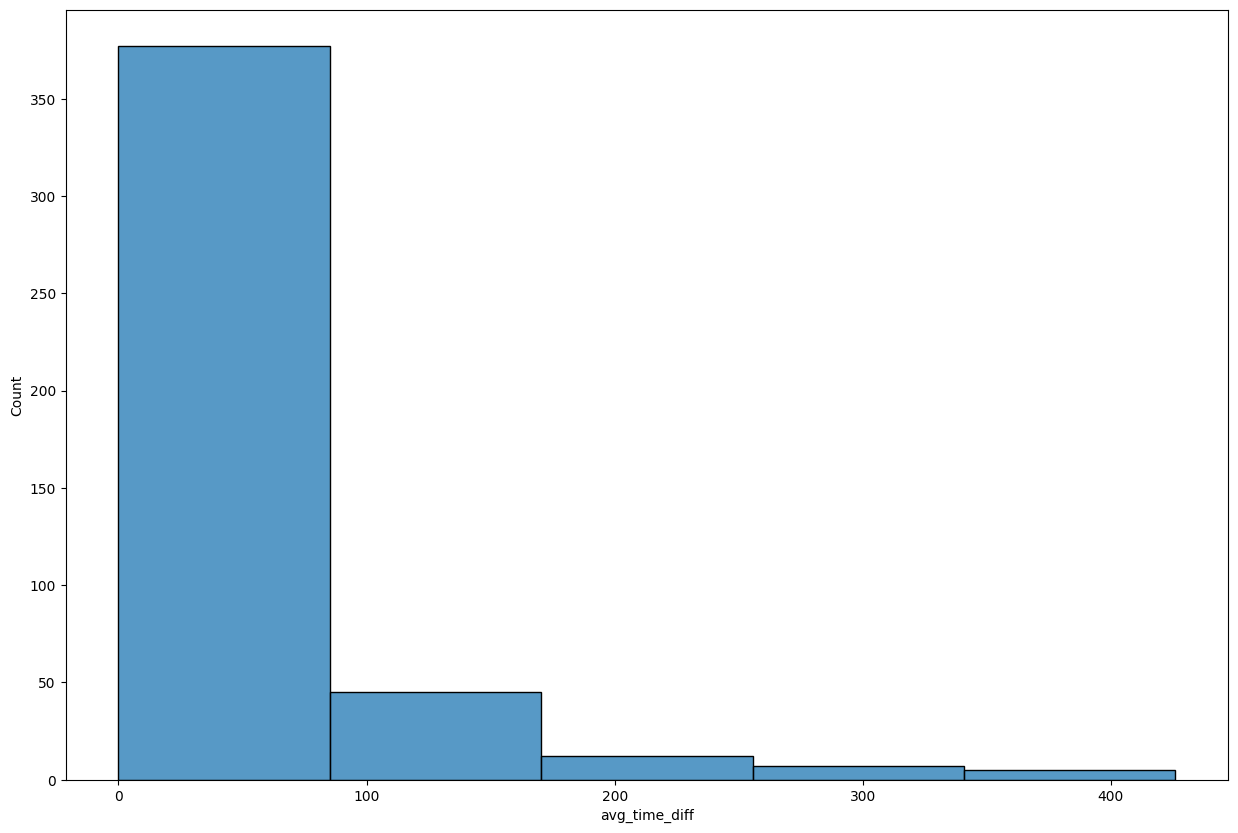

In [42]:
hist_plt_df = resubs_judje_df[(resubs_judje_df['is_resubs'] == 'O') & (resubs_judje_df['is_cancel'] == 'O')]

plt.figure(figsize=(15, 10))
sns.histplot(hist_plt_df['avg_time_diff'], bins=5)
plt.show()

---
## AARRR Funnel

### Acquisition

| 지표 | 정의 | 계산식 |
|------|------|------|
| **신규 사용자 수 (NU, New User)** | 특정 서비스에 방문한 이력이 없는 상태에서, 처음 방문하거나 상호작용한 사용자의 수 | - |
| **회원 가입 수 (Sign Up)** | 특정 서비스에 회원 가입한 사용자의 수 | - |
| **앱 다운로드 수 (App Installs)** | 특정 앱(어플리케이션)을 다운로드한 수 | - |
| **리드 수 (Leads)** | 일정 수준의 정보를 제공하는 잠재 고객, 혹은 고객 정보 그 자체의 수 | - |
| **고객 획득 비용 (CAC, Customer Acquisition Cost)** | 신규 고객 1명을 획득하기 위해 필요한 비용 | **블렌디드 CAC** : 고객 획득을 위해 투입한 전체 금액 / 획득한 전체 고객 수 <br> **매체별 CAC** : 특정 광고 매체에서 고객 획득을 위해 투입한 금액 / 해당 매체에서 획득한 고객 수 |
| **(광고) 클릭률 (CTR, Click-Through Rate)** | 광고에 노출된 사용자 중에, 광고를 클릭한 사용자의 비율 | (광고 클릭 수 / 광고 노출 수) * 100 |
| **(광고) 조회율 (VTR, View-Through Rate)** | 영상 광고에 노출된 사용자 중에, 영상을 조회한 사용자의 비율 | (광고 조회 수 / 광고 노출 수) * 100 |
| **(광고) 전환율 (CVR, Conversion Rate)** | 광고를 클릭하여 유입된 사용자 중에, 주요한 전환 행동을 한 사용자의 비율 | (전환 수 / 광고 클릭 수) * 100 |
| **CPM (Cost-Per-Mille)** | 광고 1,000번 노출당 비용 | (총 광고 비용 / 광고 노출 수) * 1000 |
| **CPC (Cost-Per-Click)** | 광고 클릭당 비용 | 총 광고 비용 / 광고 클릭 수 |
| **CPV (Cost-Per-View)** | 영상 광고 조회당 비용 | 총 광고 비용 / 광고 조회 수 |
| **CPA (Cost-Per-Action)** | 특정 액션(회원가입, 상품 구매, 이벤트 참여 등)당 비용 | 총 광고 비용 / 특정 액션이 발생한 수 |
| **CPI (Cost-Per-Install)** | 앱 설치당 비용 | 총 광고 비용 / 앱 설치 수 |

- 신규 사용자 수 = 월별 회원+비회원 통합 방문 건수 / 월별 비회원 방문 건수<br/>
- 회원 가입 수 = 월별 회원 가입 완료 건수

### Activation

| 지표 | 정의 | 계산식 |
|------|------|------|
| **체류 시간 (DT, Duration Time)** | 사용자가 특정 서비스에 머무른 시간 | **평균 체류 시간** = 총 체류 시간(사용자들이 방문하여 머무른 전체 시간) / 방문한 전체 사용자 수 |
| **평균 페이지 체류 시간 (Average Time on Page)** | 사용자가 서비스 내의 단일 페이지에서 머무른 평균 시간 | 단일 페이지의 총 체류 시간 / 해당 페이지를 방문한 사용자 수 |
| **평균 세션 시간 (Average Session Duration)** | 단일 세션 동안 사용자가 특정 서비스에서 머무른 평균 시간 | 총 세션 시간(각 세션의 ‘세션 종료 시각 - 세션 시작 시각’의 총합) / 세션 수 |
| **페이지 뷰 (PV, Page View)** | 특정 웹사이트나 서비스를 방문하여 열람한 페이지의 수 (중복 포함) | - |
| **순 방문자 수 (UV, Unique Visitor)** | 특정 웹사이트나 서비스에 방문한 사용자 중 중복되는 사용자를 배제한 순 방문자 수 | - |
| **페이지 이탈률 (Bounce Rate, 반송률)** | 웹이나 앱에서 첫 페이지만 조회한 후, 추가적인 행동이나 상호작용 없이 바로 이탈한 사용자의 비율 | (반송 수 / 방문 수) * 100 <br> *반송 수 : 랜딩 페이지에 방문하여 1PV만을 발생시킨 방문의 수* |
| **Aha-moment 전환율** | Aha-moment를 경험하는 사용자의 비율 | (Aha-moment를 경험한 사용자 수 / 전체 사용자 수) * 100 |
| **구매 전환율 / 구독 전환율** | 전체 방문자 중 구매/구독을 한 사용자의 비율 | (구매 수 or 구독 수 / 방문 수) * 100 |
| **세부 퍼널 단계별 전환율** | 세부 퍼널(Aha-moment 퍼널, 구매 퍼널, 구독 퍼널 등) 안에서의 단계별 전환율 | (이후 단계로 전환된 수 / 이전 단계의 수) * 100 |

### Retention

| 지표 | 정의 | 계산식 |
|------|------|------|
| **유지율 (Retention Rate, 잔존율)** | 사용자가 유지되는 비율 | (유지된 사용자 수 / 기존 사용자 수) * 100 |
| **이탈률 (Churn Rate)** | 사용자가 이탈하는 비율 | (이탈한 사용자 수 / 기존 사용자 수) * 100 |
| **재구매율 / 재구독률** | 첫 구매후 특정 단위 기간(1주, 1개월, 3개월 등)내에 다시 구매/구독하는 사용자의 비율 | (재구매 or 재구독한 사용자 수 / 기존 사용자 수) * 100 |
| **사용자 고착도 (Stickiness)** | 사용자가 서비스에 계속해서 방문하는 정도 | DAU(일간 활성 사용자 수) / MAU(월간 활성 사용자 수) * 100 |
| **활성 사용자 수 (AU, Active User)** | 특정 웹사이트, 앱 또는 플랫폼과 상호작용하며 활성화된 사용자 수 (중복 제거) | - |
| **기간별 활성 사용자 수** | 특정 기간 동안 활성 사용자 수 (HAU, DAU, WAU, MAU) | **HAU** : 시간당 활성 사용자 수 <br> **DAU** : 일간 활성 사용자 수 <br> **WAU** : 주간 활성 사용자 수 <br> **MAU** : 월간 활성 사용자 수 |

### Revenue

| 지표 | 정의 | 계산식 |
|------|------|------|
| **매출 (Revenue)** | 비즈니스가 고객에게 상품 혹은 서비스를 판매하여 창출하는 총 금액으로, 비즈니스 운영과 관련된 비용을 공제하기 전의 금액 | - |
| **매출총이익 (Gross Profit, 마진)** | 매출액에서 매출원가(COGS, 제품이나 서비스를 제공하는 데 드는 직접 비용)를 차감한 금액 | 매출 - 매출 원가 |
| **매출총이익률 (Gross Profit Margin, 마진율)** | 매출 대비 매출총이익(마진)의 비율 | {(매출 - 매출 원가) / 매출} * 100 |
| **순이익 (Net Profit, Net Income)** | 매출에서 매출 원가, 인건비, 광고비, 세금 등 비즈니스가 사용한 모든 비용을 차감하고 영업외수익과 비용까지 고려한 뒤 남은 금액으로, 비즈니스의 순수한 이익 | 매출 - 매출 원가 - 판매관리비 + (금융수익 - 금융비용) + (영업외수익 - 영업외비용) - 법인세비용 |
| **MRR (Monthly Recurring Revenue, 월간 반복 매출)** | 매월 반복적으로 발생하는 매출 | 기존 고객의 월간 매출(전월 매출) - 이탈 고객의 월간 기여 매출 + 신규/부활 고객의 월간 매출 + 플랜 업그레이드/다운그레이드로 인한 월간 매출 차액 |
| **ARR (Annual Recurring Revenue, 연간 반복 매출)** | 매년 반복적으로 발생하는 매출 | 기존 고객의 연간 매출(전년도 매출) - 이탈 고객의 연간 기여 매출 + 신규/부활 고객의 연간 매출 + 플랜 업그레이드/다운그레이드에 따른 연간 매출 차액 |
| **ROI (Return on Investment, 투자 수익률)** | 투자 비용(광고비를 포함한 모든 비용) 대비 수익률(순이익 기준) | (순이익 / 전체 투자 비용) * 100 |
| **ROAS (Return on Ad Spend, 광고 수익률)** | 투입한 광고 비용 대비 수익률(매출 기준) | (광고 캠페인을 통해 발생한 매출 / 투입한 총 광고 비용) * 100 <br> **매체별 ROAS** : (특정 광고 매체에서 발생한 매출 / 해당 매체에 투입한 총 광고 비용) * 100 |
| **PU (Paying User, 유료 결제 사용자 수)** | 유료 결제를 한 사용자의 수 | - |
| **ARPU (Average Revenue Per User)** | 고객 평균 매출로, 무료 사용자와 유료 결제 사용자를 포함한 전체 사용자 1인당 평균 매출 | 총 매출 / 전체 사용자 수 |
| **ARPPU (Average Revenue per Paying User)** | 유료 고객 평균 매출로, 유료 결제 사용자 1인당 평균 매출 | 총 매출 / 유료 결제 사용자 수 (PU) |
| **ARPDAU (Average Revenue Per Daily Active User)** | DAU(일간 활성 사용자) 1인당 일 평균 매출 | 일 매출 / DAU(일간 활성 사용자 수) |
| **LTR (Lifetime Revenue, 고객 생애 매출)** | 고객 한 명이 제품/서비스를 이용하는 전체 생애 동안 우리 비즈니스에서 발생시킬 것으로 예상되는 기대 매출 | 고객이 생애 동안 누적하여 발생시킨 총 매출의 합 / 고객 수 |
| **LTV (Lifetime Value, 고객 생애 가치)** | 고객 한 명이 제품/서비스를 이용하는 전체 생애 동안 우리 비즈니스에서 발생시킬 것으로 예상되는 기대 가치(순이익 기준) | {평균 구매 금액 * 마진율 * 구매 빈도(구매 횟수) * 고객 수명} - (고객 획득 비용 + 고객 유지 비용) |

### Referral

| 지표 | 정의 | 계산식 |
|------|------|------|
| **바이럴 주기 시간 (Viral Cycle Time)** | 기존 사용자가 친구를 초대하고, 초대받은 친구가 신규 사용자로 유입되기까지 걸리는 시간 | - |
| **바이럴 계수 (Viral Coefficient)** | 기존 사용자 1명당 만들어내는 신규 사용자의 수 | 기존 사용자 1명당 평균 친구 초대 수 * 초대받은 친구의 초대 수락 비율 |
| **NPS (Net Promoter Score, 순 추천 지수)** | 기존 사용자가 제품이나 서비스, 브랜드를 추천할 가능성으로, 고객 충성도를 측정하는 표준 척도 | 추천 그룹의 비율(%) - 비추천 그룹의 비율(%) |
| **SNS 공유 수 (SNS Share Rate)** | 공유 수, 댓글 수, 태그 수 등 | - |